In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/dataset_ml/weatherAUS.csv')

In [ ]:
print(df.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

In [ ]:
df.dropna(subset="RainTomorrow", inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)

In [ ]:
df.isnull().sum()

,0
Location,0
MinTemp,637
MaxTemp,322
Rainfall,1406
Evaporation,60843
Sunshine,67816
WindGustDir,9330
WindGustSpeed,9270
WindDir9am,10013
WindDir3pm,3778


In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [ ]:
label_encoders = {}

for col in categorical_cols:
  le = LabelEncoder()
  df[col] = df[col].astype(str)
  df[col] = le.fit_transform(df[col])
  label_encoders[col] = le


In [ ]:
X = df.drop(columns=['RainTomorrow']) # Features
y = df['RainTomorrow']                # Target (0: No, 1: Yes)

# Chia tỉ lệ 80% Train - 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- BƯỚC 4: KHỞI TẠO VÀ TRAIN MODEL XGBOOST ---

# scale_pos_weight: Giúp cân bằng dữ liệu (số lượng No > Yes)
# Công thức ước lượng: sum(negative) / sum(positive)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(
    n_estimators=500,       # Số lượng cây (trees)
    learning_rate=0.05,     # Tốc độ học
    max_depth=6,            # Độ sâu tối đa của cây (tránh overfitting)
    scale_pos_weight=pos_weight, # Xử lý mất cân bằng dữ liệu
    n_jobs=-1,              # Dùng tất cả CPU core
    random_state=42,
    early_stopping_rounds=10 # Dừng nếu sau 10 vòng không cải thiện (cần eval_set)
)

print("Đang train model... (Vui lòng đợi)")
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], # Đưa tập test vào để theo dõi quá trình học
    verbose=False
)

Đang train model... (Vui lòng đợi)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)


--- KẾT QUẢ ĐÁNH GIÁ ---
Accuracy Score: 0.8266

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     22064
           1       0.58      0.80      0.67      6375

    accuracy                           0.83     28439
   macro avg       0.76      0.82      0.78     28439
weighted avg       0.86      0.83      0.84     28439



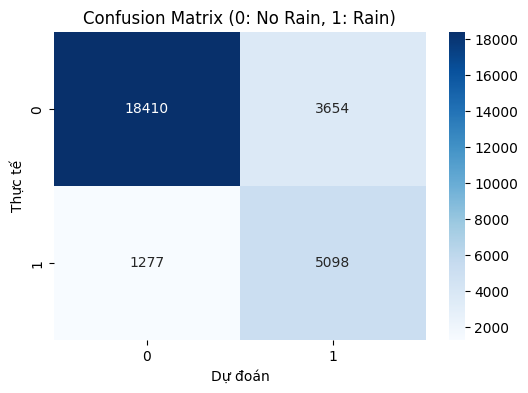

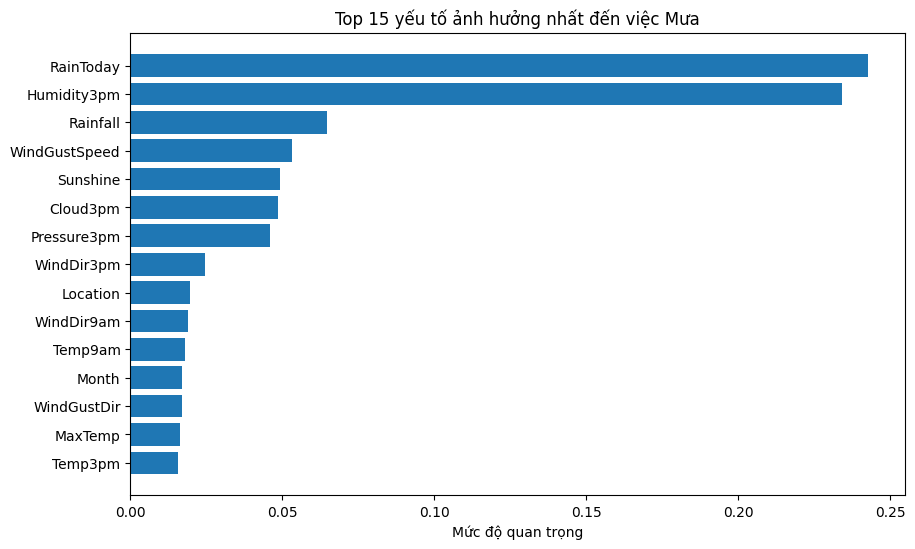

In [ ]:
# Dự đoán
y_pred = model.predict(X_test)

# In kết quả
print("\n--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (0: No Rain, 1: Rain)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# --- BƯỚC 6: XEM FEATURE IMPORTANCE (Yếu tố nào quan trọng nhất?) ---
plt.figure(figsize=(10, 6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][-15:], model.feature_importances_[sorted_idx][-15:])
plt.title("Top 15 yếu tố ảnh hưởng nhất đến việc Mưa")
plt.xlabel("Mức độ quan trọng")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đã load dữ liệu thành công! Kích thước: (145460, 23)
Đang train model LightGBM...

--- KẾT QUẢ LIGHTGBM ---
Accuracy: 0.8307
              precision    recall  f1-score   support

           0       0.93      0.84      0.89     22064
           1       0.59      0.79      0.68      6375

    accuracy                           0.83     28439
   macro avg       0.76      0.82      0.78     28439
weighted avg       0.86      0.83      0.84     28439



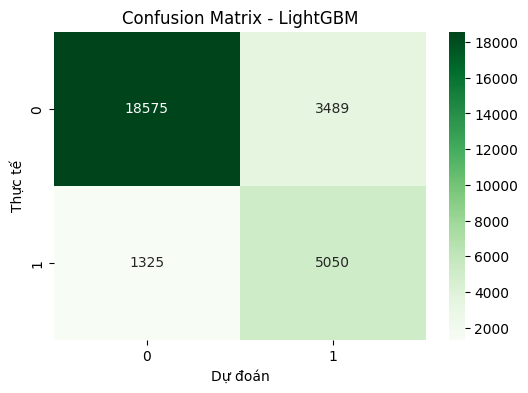

<Figure size 1000x800 with 0 Axes>

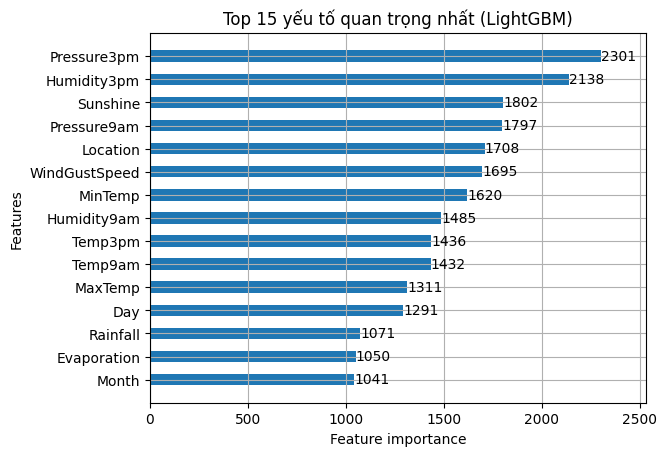

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
from lightgbm import LGBMClassifier

# --- BƯỚC 1: KẾT NỐI GOOGLE DRIVE (Đã sửa lại đường dẫn chuẩn) ---
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn file (Lưu ý: Bạn hãy kiểm tra lại đúng tên thư mục của bạn trong 'My Drive')
# Ví dụ: nếu file nằm trong folder 'dataset_ml' của 'My Drive'
file_path = '/content/drive/My Drive/dataset_ml/weatherAUS.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Đã load dữ liệu thành công! Kích thước: {df.shape}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file. Hãy kiểm tra lại đường dẫn trong biến 'file_path'")
    # Dừng chương trình nếu không thấy file
    raise

# --- BƯỚC 2: TIỀN XỬ LÝ (PREPROCESSING) ---

# 1. Xóa dòng thiếu Target
df.dropna(subset=['RainTomorrow'], inplace=True)

# 2. Xử lý thời gian
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns=['Date'], inplace=True)

# 3. Xử lý Categorical Data
# LightGBM có thể xử lý category trực tiếp nếu khai báo dtype='category',
# nhưng để an toàn và đơn giản nhất cho người mới, ta vẫn dùng LabelEncoder
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

# --- BƯỚC 3: CHIA DỮ LIỆU ---
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- BƯỚC 4: TRAIN MODEL LIGHTGBM ---

# Tính toán tỉ lệ cân bằng (Scale pos weight)
# Số lượng mẫu Âm tính / Số lượng mẫu Dương tính
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Khởi tạo LightGBM Classifier
model = LGBMClassifier(
    n_estimators=1000,      # Số lượng cây
    learning_rate=0.05,     # Tốc độ học
    num_leaves=31,          # Quan trọng: Số lá tối đa trên 1 cây (thay thế vai trò của max_depth)
    max_depth=-1,           # -1 nghĩa là không giới hạn độ sâu (để num_leaves quyết định)
    scale_pos_weight=pos_weight, # Xử lý mất cân bằng dữ liệu
    random_state=42,
    n_jobs=-1,              # Dùng tối đa CPU
    verbose=-1              # Tắt các thông báo warning không cần thiết
)

print("Đang train model LightGBM...")
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss'
    # LightGBM sklearn API mới không cần verbose=False ở đây nếu đã set ở trên
)

# --- BƯỚC 5: ĐÁNH GIÁ ---
y_pred = model.predict(X_test)

print("\n--- KẾT QUẢ LIGHTGBM ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# --- BƯỚC 6: FEATURE IMPORTANCE ---
# LightGBM cung cấp hàm vẽ biểu đồ có sẵn rất tiện
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 yếu tố quan trọng nhất (LightGBM)")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đang train Logistic Regression...

--- KẾT QUẢ LOGISTIC REGRESSION ---
Accuracy: 0.7906
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     22064
           1       0.52      0.77      0.62      6375

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.74     28439
weighted avg       0.83      0.79      0.80     28439



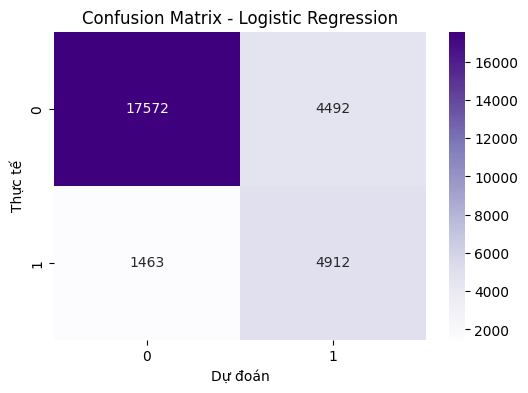

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- BƯỚC 1: LOAD DATA ---
from google.colab import drive
drive.mount('/content/drive')

# Hãy sửa lại đường dẫn đúng với file của bạn
file_path = '/content/drive/My Drive/dataset_ml/weatherAUS.csv'
df = pd.read_csv(file_path)

# --- BƯỚC 2: TIỀN XỬ LÝ (Khác biệt so với XGBoost) ---

# 1. Xóa dòng thiếu Target (Bắt buộc)
df.dropna(subset=['RainTomorrow'], inplace=True)

# 2. Xử lý Date
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns=['Date'], inplace=True)

# 3. Tách biến Categorical và Numerical
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Loại bỏ RainTomorrow khỏi danh sách numerical nếu nó đang ở đó (để xử lý riêng)
numerical_cols = numerical_cols.drop('RainTomorrow', errors='ignore') if 'RainTomorrow' in numerical_cols else numerical_cols

# 4. Xử lý Missing Values (Logistic Regression KHÔNG chạy được nếu còn NaN)
# - Với số: Điền bằng trung vị (median) để tránh outlier
imputer_num = SimpleImputer(strategy='median')
df[numerical_cols] = imputer_num.fit_transform(df[numerical_cols])

# - Với chữ: Điền bằng giá trị xuất hiện nhiều nhất (most_frequent)
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

# 5. Encoding (Chuyển chữ thành số)
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 6. Encode Target (Yes/No -> 1/0)
le_target = LabelEncoder()
df['RainTomorrow'] = le_target.fit_transform(df['RainTomorrow'])

# --- BƯỚC 3: CHUẨN HÓA DỮ LIỆU (Scaling) - Quan trọng với Logistic Regression ---
# Đưa tất cả về dạng chuẩn (Mean=0, Std=1) để model hội tụ nhanh và chính xác
scaler = StandardScaler()
feature_cols = [c for c in df.columns if c != 'RainTomorrow']
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# --- BƯỚC 4: CHIA DỮ LIỆU ---
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- BƯỚC 5: TRAIN LOGISTIC REGRESSION ---
print("Đang train Logistic Regression...")
# max_iter=1000 để đảm bảo thuật toán đủ thời gian tìm ra đáp án tối ưu
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# --- BƯỚC 6: ĐÁNH GIÁ ---
y_pred = model.predict(X_test)

print("\n--- KẾT QUẢ LOGISTIC REGRESSION ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

In [ ]:
# 1. Cài đặt các thư viện cần thiết
!pip install -q streamlit pyngrok joblib

import joblib
import pandas as pd

# 2. GIẢ LẬP LƯU MODEL (Nếu bạn đã có model thật ở biến 'model', hãy bỏ qua dòng này)
# Ở đây mình tạo một ví dụ giả để code chạy được ngay,
# thực tế bạn sẽ dùng: joblib.dump(your_trained_model, 'weather_model.pkl')
# from sklearn.linear_model import LogisticRegression
# dummy_X = [[20, 50], [30, 80], [15, 60]] # Temp, Humidity
# dummy_y = [0, 1, 0] # No, Yes, No
# model = LogisticRegression()
# model.fit(dummy_X, dummy_y)

# 3. Lưu model vào đĩa cứng (Google Colab)
joblib.dump(model, 'xgboost_final.pkl')
print("Đã lưu model thành công vào file 'weather_model.pkl'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.4 MB/s eta 0:00:00
Đã lưu model thành công vào file 'weather_model.pkl'


In [ ]:
# --- BƯỚC 1: HUẤN LUYỆN VÀ LƯU ĐẦY ĐỦ MODEL + ENCODERS ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import joblib

# 1. Load và Tiền xử lý dữ liệu (Giống hệt quá trình train trước đó)
try:
    # Đảm bảo đường dẫn file đúng
    df = pd.read_csv('/content/drive/My Drive/dataset_ml/weatherAUS.csv')
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file weatherAUS.csv. Kiểm tra lại đường dẫn mount drive!")
    raise

df.dropna(subset=['RainTomorrow'], inplace=True)
# Xóa cột Date để đơn giản hóa input cho Web App
df.drop(columns=['Date'], inplace=True)

# Xử lý Missing Values đơn giản (Điền bằng 0 hoặc 'Unknown') để đảm bảo chạy được
# Trong thực tế bạn nên dùng phương pháp điền median/mode tốt hơn
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')


# 2. QUAN TRỌNG: Mã hóa và lưu lại các "Từ điển" (LabelEncoders)
encoders_dict = {} # Từ điển chứa các bộ mã hóa
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    # Fit và transform dữ liệu
    df[col] = le.fit_transform(df[col])
    # Lưu lại bộ encoder để dùng cho Web App sau này
    encoders_dict[col] = le
    # In ra để kiểm tra
    # print(f"Đã lưu encoder cho cột: {col}. Các giá trị: {le.classes_[:5]}...")


# 3. Chia dữ liệu và Train XGBoost
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

# Lưu lại thứ tự các cột (Feature names) để đảm bảo Web App nhập đúng thứ tự
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tính scale_pos_weight
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1
)

print("⏳ Đang huấn luyện mô hình XGBoost thật (sẽ mất vài giây)...")
model.fit(X_train, y_train)
print("✅ Huấn luyện xong!")

# 4. LƯU TẤT CẢ FILE CẦN THIẾT
joblib.dump(model, 'xgboost_final.pkl')
joblib.dump(encoders_dict, 'encoders_dict.pkl')
joblib.dump(feature_names, 'feature_names.pkl')

print("\n🎉 ĐÃ LƯU THÀNH CÔNG 3 FILE QUAN TRỌNG:")
print("1. xgboost_final.pkl (Mô hình)")
print("2. encoders_dict.pkl (Bộ mã hóa chữ sang số)")
print("3. feature_names.pkl (Thứ tự các đặc trưng)")

⏳ Đang huấn luyện mô hình XGBoost thật (sẽ mất vài giây)...
✅ Huấn luyện xong!

🎉 ĐÃ LƯU THÀNH CÔNG 3 FILE QUAN TRỌNG:
1. xgboost_final.pkl (Mô hình)
2. encoders_dict.pkl (Bộ mã hóa chữ sang số)
3. feature_names.pkl (Thứ tự các đặc trưng)


In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np

# --- CẤU HÌNH TRANG ---
st.set_page_config(page_title="Dự báo Thời tiết Úc", page_icon="🌦️", layout="wide")

# --- LOAD CÁC FILE ĐÃ LƯU ---
@st.cache_resource # Cache để không phải load lại mỗi lần f5
def load_artifacts():
    try:
        model = joblib.load('xgboost_final.pkl')
        encoders = joblib.load('encoders_dict.pkl')
        features = joblib.load('feature_names.pkl')
        return model, encoders, features
    except FileNotFoundError as e:
        st.error(f"❌ Lỗi: Không tìm thấy file cần thiết. Hãy chắc chắn bạn đã chạy Bước 1 thành công. Chi tiết: {e}")
        return None, None, None

model, encoders_dict, feature_names = load_artifacts()

if not model:
    st.stop() # Dừng app nếu không load được model

# --- GIAO DIỆN NHẬP LIỆU ---
st.title("🌦️ Hệ thống Dự báo Mưa Thông minh (XGBoost)")
st.markdown("Hãy nhập đầy đủ các thông số thời tiết bên dưới để mô hình AI phân tích.")

# Tạo từ điển chứa dữ liệu người dùng nhập vào
user_input = {}

# --- NHÓM 1: THÔNG TIN CHUNG ---
with st.expander("📍 Vị trí & Tình trạng mưa hôm nay", expanded=True):
    col1, col2 = st.columns(2)
    with col1:
        # Lấy danh sách địa điểm từ encoder đã lưu
        location_options = encoders_dict['Location'].classes_.tolist()
        user_input['Location'] = st.selectbox("Chọn địa điểm (Location)", location_options, index=location_options.index('Sydney') if 'Sydney' in location_options else 0)
    with col2:
        rain_today_options = encoders_dict['RainToday'].classes_.tolist()
        user_input['RainToday'] = st.radio("Hôm nay có mưa không? (RainToday)", rain_today_options)

# --- NHÓM 2: NHIỆT ĐỘ & LƯỢNG MƯA ---
with st.expander("🌡️ Nhiệt độ, Lượng mưa & Nắng"):
    col1, col2, col3 = st.columns(3)
    with col1:
        user_input['MinTemp'] = st.number_input("Nhiệt độ thấp nhất (°C)", value=15.0, step=0.5)
        user_input['MaxTemp'] = st.number_input("Nhiệt độ cao nhất (°C)", value=25.0, step=0.5)
    with col2:
        user_input['Temp9am'] = st.number_input("Nhiệt độ lúc 9am (°C)", value=18.0, step=0.5)
        user_input['Temp3pm'] = st.number_input("Nhiệt độ lúc 3pm (°C)", value=23.0, step=0.5)
    with col3:
        user_input['Rainfall'] = st.number_input("Lượng mưa hôm nay (mm)", value=0.0, min_value=0.0, step=0.2)
        user_input['Evaporation'] = st.number_input("Lượng bốc hơi (mm)", value=5.0, step=0.5)
        user_input['Sunshine'] = st.number_input("Số giờ nắng (giờ)", value=8.0, min_value=0.0, max_value=15.0, step=0.5)

# --- NHÓM 3: GIÓ ---
with st.expander("💨 Thông tin về Gió"):
    col1, col2, col3 = st.columns(3)
    # Lấy các option hướng gió
    dir_options = encoders_dict['WindGustDir'].classes_.tolist()

    with col1:
        st.markdown("**Gió giật mạnh nhất (Gust)**")
        user_input['WindGustDir'] = st.selectbox("Hướng gió giật", dir_options)
        user_input['WindGustSpeed'] = st.slider("Tốc độ gió giật (km/h)", 0, 150, 40)
    with col2:
        st.markdown("**Gió lúc 9am**")
        user_input['WindDir9am'] = st.selectbox("Hướng gió 9am", dir_options, key='w9')
        user_input['WindSpeed9am'] = st.slider("Tốc độ gió 9am (km/h)", 0, 100, 15)
    with col3:
        st.markdown("**Gió lúc 3pm**")
        user_input['WindDir3pm'] = st.selectbox("Hướng gió 3pm", dir_options, key='w3')
        user_input['WindSpeed3pm'] = st.slider("Tốc độ gió 3pm (km/h)", 0, 100, 20)

# --- NHÓM 4: ĐỘ ẨM, ÁP SUẤT & MÂY ---
with st.expander("💧 Độ ẩm, Áp suất & Mây"):
    col1, col2 = st.columns(2)
    with col1:
        user_input['Humidity9am'] = st.slider("Độ ẩm 9am (%)", 0, 100, 70)
        user_input['Humidity3pm'] = st.slider("Độ ẩm 3pm (%)", 0, 100, 50)
        user_input['Cloud9am'] = st.slider("Lượng mây 9am (oktas)", 0, 9, 4)
    with col2:
        user_input['Pressure9am'] = st.number_input("Áp suất 9am (hPa)", value=1015.0, step=1.0)
        user_input['Pressure3pm'] = st.number_input("Áp suất 3pm (hPa)", value=1012.0, step=1.0)
        user_input['Cloud3pm'] = st.slider("Lượng mây 3pm (oktas)", 0, 9, 5)

# --- XỬ LÝ DỰ ĐOÁN ---
st.markdown("---")
predict_btn = st.button("🚀 PHÂN TÍCH & DỰ BÁO NGAY", type="primary", use_container_width=True)

if predict_btn:
    with st.spinner("Đang xử lý dữ liệu và chạy mô hình XGBoost..."):
        try:
            # 1. Chuyển dictionary input thành DataFrame
            input_df = pd.DataFrame([user_input])

            # 2. MÃ HÓA DỮ LIỆU CHỮ SANG SỐ (Bước quan trọng nhất!)
            # Dùng lại các encoder đã lưu trong encoders_dict
            categorical_cols = input_df.select_dtypes(include=['object']).columns
            for col in categorical_cols:
                le = encoders_dict[col]
                input_df[col] = le.transform(input_df[col])

            # 3. SẮP XẾP LẠI THỨ TỰ CỘT CHO ĐÚNG VỚI LÚC TRAIN
            input_df = input_df[feature_names]

            # 4. Dự báo
            prediction = model.predict(input_df)[0]
            probability = model.predict_proba(input_df)[0][1] # Xác suất mưa (lớp 1)

            # 5. Hiển thị kết quả
            st.markdown("### 🎯 KẾT QUẢ DỰ BÁO:")
            col_res1, col_res2 = st.columns([1, 2])

            with col_res1:
                if prediction == 1:
                    st.image("https://media.giphy.com/media/PbOaO2qeCAzuAFscLv/giphy.gif", width=200)
                else:
                    st.image("https://media.giphy.com/media/FnHcBA52d2v4XqT63s/giphy.gif", width=200)

            with col_res2:
                if prediction == 1:
                    st.error(f"### 🌧️ CẢNH BÁO: NGÀY MAI CÓ MƯA!")
                    st.metric(label="Xác suất mưa", value=f"{probability*100:.1f}%", delta="Cao")
                    st.write("Hãy nhớ mang theo ô hoặc áo mưa khi ra đường nhé.")
                else:
                    st.success(f"### ☀️ YÊN TÂM: NGÀY MAI TRỜI TẠNH RÁO.")
                    st.metric(label="Xác suất mưa", value=f"{probability*100:.1f}%", delta="-Thấp", delta_color="inverse")
                    st.write("Một ngày tuyệt vời cho các hoạt động ngoài trời.")

        except Exception as e:
            st.error(f"Đã xảy ra lỗi trong quá trình xử lý: {e}")
            st.write("Vui lòng kiểm tra lại các thông số đầu vào.")

Writing app.py


In [ ]:
# 1. Cài đặt (nếu chưa có) và Cấu hình để tránh lỗi treo
!pip install -q pyngrok streamlit
!mkdir -p ~/.streamlit
content = """
[server]
headless = true
enableCORS = false
enableXsrfProtection = false
"""
with open("/root/.streamlit/config.toml", "w") as f:
    f.write(content)

# 2. Code chạy Ngrok
from pyngrok import ngrok
import time

# --- THAY TOKEN CỦA BẠN VÀO ĐÂY ---
NGROK_AUTH_TOKEN = "2YDpM1OgYVqlEhPsEugNAWTrPfP_7SpkLiBVoiWYsYXsF1Uq3"
# ----------------------------------

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Tắt các process cũ
!pkill streamlit
ngrok.kill()

# Chạy Streamlit nền
print("Đang khởi động Streamlit...")
!streamlit run app.py &>/dev/null&

time.sleep(5) # Đợi chút

try:
    # Mở kết nối Ngrok
    public_url = ngrok.connect(8501).public_url
    print(f"\n🎉 XONG RỒI! Web App XGBoost của bạn đang chạy tại:")
    print(f"👉 {public_url}")
    print("(Bấm vào link trên và chọn 'Visit Site' nếu thấy cảnh báo)")
except Exception as e:
    print(f"Lỗi Ngrok: {e}")

Đang khởi động Streamlit...

🎉 XONG RỒI! Web App XGBoost của bạn đang chạy tại:
👉 https://9029a4f19396.ngrok-free.app
(Bấm vào link trên và chọn 'Visit Site' nếu thấy cảnh báo)
